# Projet HumanForYou

## Création des imports
Cette partie est utilisée afin d'importer les principales librairies et aussi pour créer une graine afin d'obtenir des résultats traitables sur différents notebooks ainsi que toutes les fonctions afin de clarifier le code plus loin.

In [1]:
# imports
import numpy as np
import os
import pandas as pd
import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score

#removes warnings about soon deprecated functions 
import warnings
warnings.filterwarnings('ignore')

#matplotlib 
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from numpy.random import default_rng
# project seed
random=default_rng(0) 

pd.set_option('display.max_columns', None)

In [2]:
#Loads employees data inside a dataframe
def load_employees_data():
    #loading data from csvs
    employeeSurvey = os.path.join('data', 'employee_survey_data.csv')
    generalData    = os.path.join('data', 'general_data.csv')
    inTime         = os.path.join('data', 'in_time.csv')
    managerSurvey  = os.path.join('data', 'manager_survey_data.csv')
    outTime        = os.path.join('data', 'out_time.csv')
    
    #return all DataFrames
    return pd.read_csv(employeeSurvey), pd.read_csv(generalData), pd.read_csv(inTime), pd.read_csv(managerSurvey), pd.read_csv(outTime)

#verify the data inside the dataframes to avoid any issues with incomplete data
def dataframeVerifier(dataframes: {}):
    #looping through array of dataframes
    for df in dataframes:
        nanValues = dataframes[df].isna().sum().sum()
        dfLength  = len(dataframes[df].index)
        print(f"le dataframe {df} contient {nanValues} valeur a NaN et contient {dfLength} lignes") 
    return

#converts strings to date format
def timeConvert():
    # coerce va remplacer gérer les erreurs
    inTime.iloc[:, 1:] = inTime.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')
    outTime.iloc[:, 1:] = outTime.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')
    
# renames the first index of the dataset
def renameFirstIndex(dataframes, name):
    columnsName = dataframes.columns.tolist()
    columnsName[0] = name
    dataframes.columns = columnsName
    return dataframes

#casts string dates as dateformat
def setTimeToHour(x):
    return x.dt.components['hours'] + (x.dt.components['minutes'] / 60)

#computes values for our final time DataFrame
def createTimeDataFrame():
    timeDF = outTime - inTime
    timeDF["EmployeeID"] = outTime["EmployeeID"]
    
    #getting wanted values from in and out time
    meanWorkTime = timeDF.iloc[:, 1:].apply(setTimeToHour)
    absentDays = timeDF.iloc[:, 1:].isna().sum(axis=1)
    presentDays = timeDF.iloc[:, 1:].notnull().sum(axis=1)
    
    finalTime["meanPresenceTime"] = meanWorkTime.mean(axis=1)
    finalTime["absentDays"] = absentDays
    finalTime["presentDays"] = presentDays
    
#setting all values to numerical ones
def settingNumericalData(df, columns):
    for column in columns:
        i=0
        mapData={}
        values = df[column].unique()
        for value in values:
            mapData[value] = i
            print(f'{value} as for key {i}')
            i+=1 
        df[column] = df[column].map(mapData)
        print()
    

## Création des datasets
La première tâche va être de créer des dataframes pandas, afin de pouvoir utiliser les données mais aussi d'utiltérieurement les valider afin de ne pas avoir de valeurs abbérantes ou fausses.

La première partie du code sera utilisée afin de charger les datasets.

In [3]:
#sending DF to variables for future use
employeeSurvey, generalData, inTime, managerSurvey, outTime = load_employees_data()

## Vérification des datasets
Afin de pouvoir traiter les données, il est bon de faire une simple vérification sur le nombre de lignes afin de voir si cela concorde entre les fichiers, mais aussi le taux de valeurs non définies. Afin de pouvoir créer un dataframe final utilisé lors du traitement des données.

In [4]:
dataframeVerifier({"employeeSurvey": employeeSurvey,
                   "generalData":generalData, 
                   "inTime":inTime, 
                   "managerSurvey":managerSurvey, 
                   "outTime":outTime})

le dataframe employeeSurvey contient 83 valeur a NaN et contient 4410 lignes
le dataframe generalData contient 28 valeur a NaN et contient 4410 lignes
le dataframe inTime contient 109080 valeur a NaN et contient 4410 lignes
le dataframe managerSurvey contient 0 valeur a NaN et contient 4410 lignes
le dataframe outTime contient 109080 valeur a NaN et contient 4410 lignes


### Analyse des résultats obtenus
Ici il est visible que les datasets contiennent le même nombre de lignes ce qui les rends compatible à une fusion ce qui valide l'hypothèse principale de travailler sur un dataframe final étant la fusion des autres.

on peut aussi voir certaines valeurs a NaN, signifiant qu'elles ne sont pas renseignées, il existe cependant un cas qui paraît un peu préoccupant les dataframes inTime et outTime, qui possèdent 109080 valeurs a NaN. Mais ces données continnent les résultats de la badgeuse, il faut donc prendre en compte que les employés prennent des vacances, tombent malades.

Cette analyse permet donc d'expliquer ce grand nombre de valeurs à NaN obtenues.

Ces valeurs semble correctes il reste cependant une manipulation à faire afin de fusionner les tables inTime et outTime, afin de pouvoir calculer les heures de travail effectuées par un employé et non ses horraires d'entrée et de sortie.

Dès lors que le temps est calculé pourt chaque occurence, le calcul d'une durée moyenne de la journée de travail pourrait donner une indication pertinente à utiliser dans notre projet.

## Création d'un jeu de donnée du temp de travail.

In [5]:
#renomme le premier indexe à EmployeeID
outTime = renameFirstIndex(outTime, 'EmployeeID')
inTime = renameFirstIndex(inTime, 'EmployeeID')

timeConvert()

#creating final dataframe for time csv and adding employee id to it
finalTime = pd.DataFrame()
finalTime["EmployeeID"] = generalData["EmployeeID"].copy()

createTimeDataFrame()

## Création d'un jeu de données global afin de faciliter les futurs traitements.
Nous allons donc calculer le taux de turnover en 2016 grâce à notre dataframe, afin de dégager une valeur et la correller aux valeurs du dataframe.
On enlève aussi l'EmployeeID et le EmployeeCount.
Nous pouvons aussi supprimer les valeurs présentes à NaN car comme vu précedemment cela représente 111 valeurs au maximum.

Healthcare Representative as for key 0
Research Scientist as for key 1
Sales Executive as for key 2
Human Resources as for key 3
Research Director as for key 4
Laboratory Technician as for key 5
Manufacturing Director as for key 6
Sales Representative as for key 7
Manager as for key 8

Female as for key 0
Male as for key 1

No as for key 0
Yes as for key 1

Y as for key 0

Married as for key 0
Single as for key 1
Divorced as for key 2

Travel_Rarely as for key 0
Travel_Frequently as for key 1
Non-Travel as for key 2

Sales as for key 0
Research & Development as for key 1
Human Resources as for key 2

Life Sciences as for key 0
Other as for key 1
Medical as for key 2
Marketing as for key 3
Technical Degree as for key 4
Human Resources as for key 5

 le taux de turnover en 2016 est de 16.1%


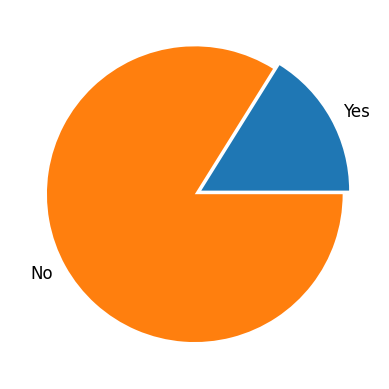

In [6]:
#setting merged DF
employeeData = generalData.merge(employeeSurvey, on="EmployeeID", how="inner")
employeeData = employeeData.merge(managerSurvey, on="EmployeeID", how="inner")
employeeData = employeeData.merge(finalTime, on="EmployeeID", how="inner")
employeeData = employeeData.drop(columns=['EmployeeID','EmployeeCount'])

settingNumericalData(employeeData, ['JobRole', 'Gender', 'Attrition', 'Over18', 'MaritalStatus', 'BusinessTravel', 'Department', 'EducationField'])

#turnover percentage calculation
turnoverPercentage = ((employeeData['Attrition'] == 1).sum() / employeeData['Attrition'].shape[0]) * 100

#status prompting + plotting
print(f' le taux de turnover en 2016 est de {turnoverPercentage:.1f}%')
plt.pie([turnoverPercentage, 100-turnoverPercentage], labels=["Yes", "No"], explode = (0.05, 0))

# dropping NaN values
employeeData = employeeData.dropna()

<Axes: >

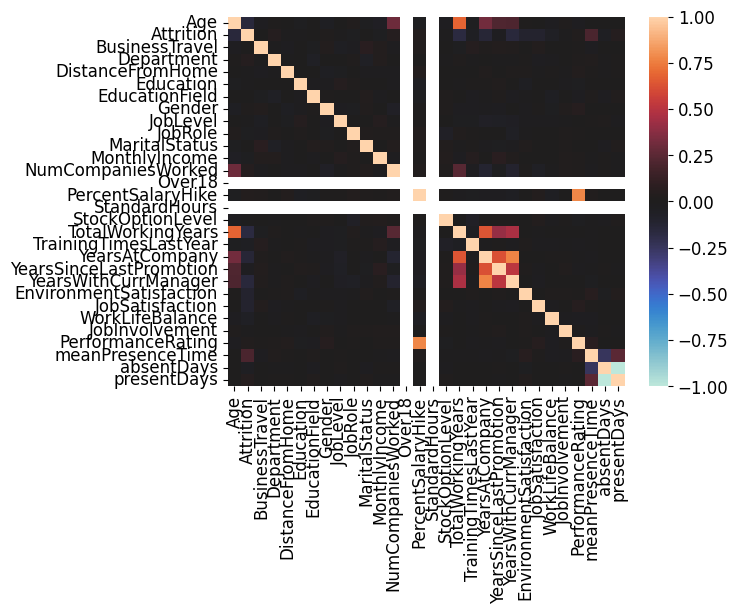

In [7]:
#corellation matrix
sns.heatmap(employeeData.corr(numeric_only="true"), xticklabels=True, yticklabels=True, center=0)

## Création d'un modèle d'intelligence artificielle

In [8]:
#Data preprocessing
for column in employeeData.columns:
    if employeeData[column].dtype==np.number:
        continue
    else:
        employeeData[column]=LabelEncoder().fit_transform(employeeData[column])

In [9]:
#Setting up the randomForestClassifier
randomForest = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=42)

In [10]:
#creating trainning data and testing data
x = employeeData.drop("Attrition", axis=1)
y = employeeData["Attrition"].copy()

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

In [15]:
#Starting forest classification
randomForest.fit(xTrain, yTrain)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [16]:
#Starting trainning of the AI
randomForest.score(xTrain, yTrain)

0.9982558139534884

In [18]:
# We look for hyperparameters that have the most impact on the model
importances = pd.DataFrame({'feature': xTrain.columns, 'importance': randomForest.feature_importances_})
importances.sort_values(by='importance', ascending=False, inplace=True)

importances.head(10)

,feature,importance
26,meanPresenceTime,0.124849
10,MonthlyIncome,0.079405
16,TotalWorkingYears,0.072848
0,Age,0.069125
18,YearsAtCompany,0.054931
8,JobRole,0.043142
19,YearsSinceLastPromotion,0.041824
13,PercentSalaryHike,0.041801
3,DistanceFromHome,0.041471
11,NumCompaniesWorked,0.035322


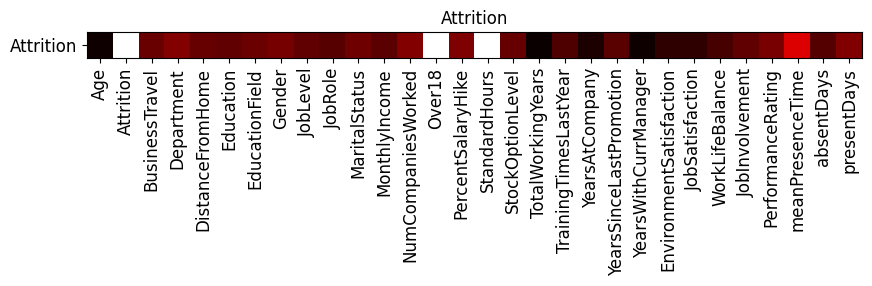

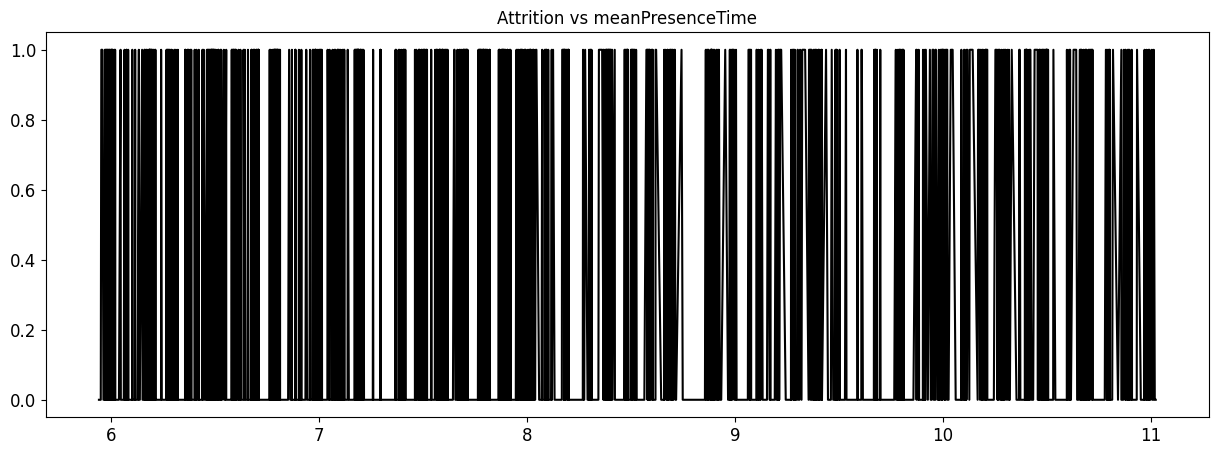

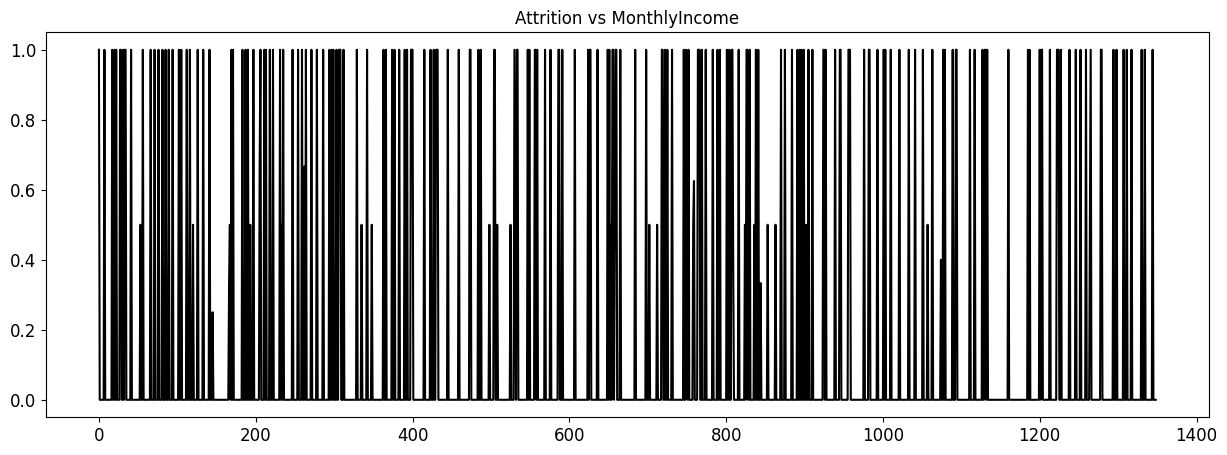

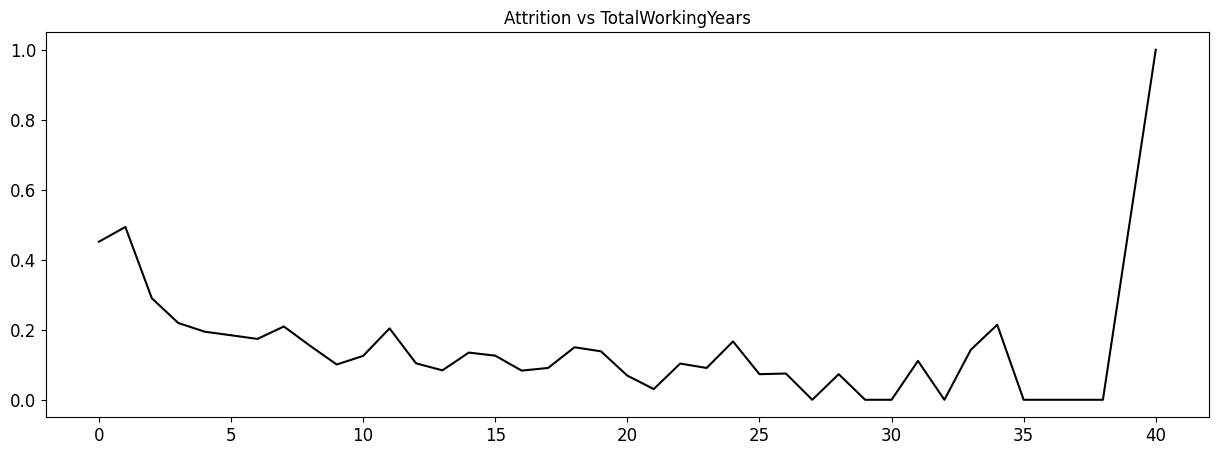

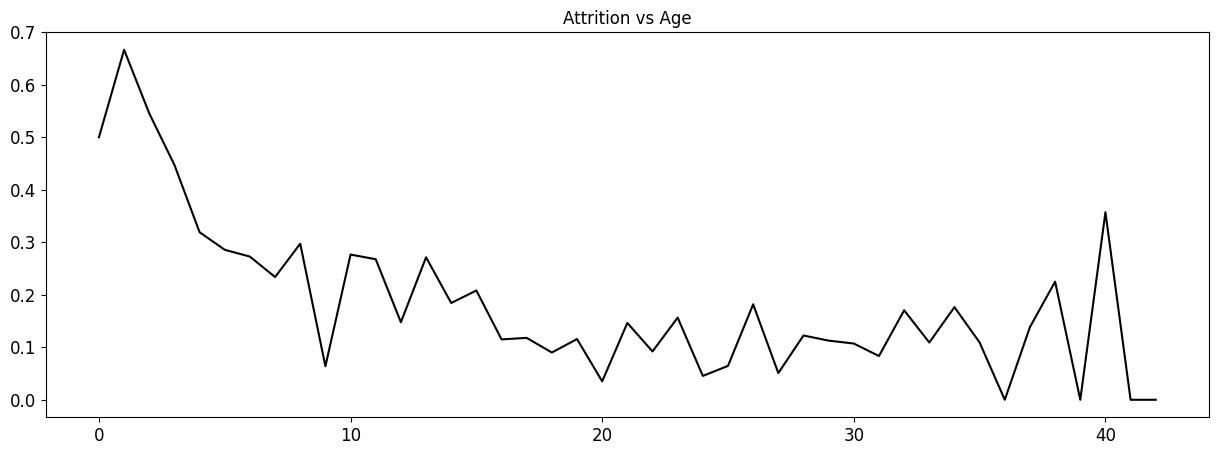

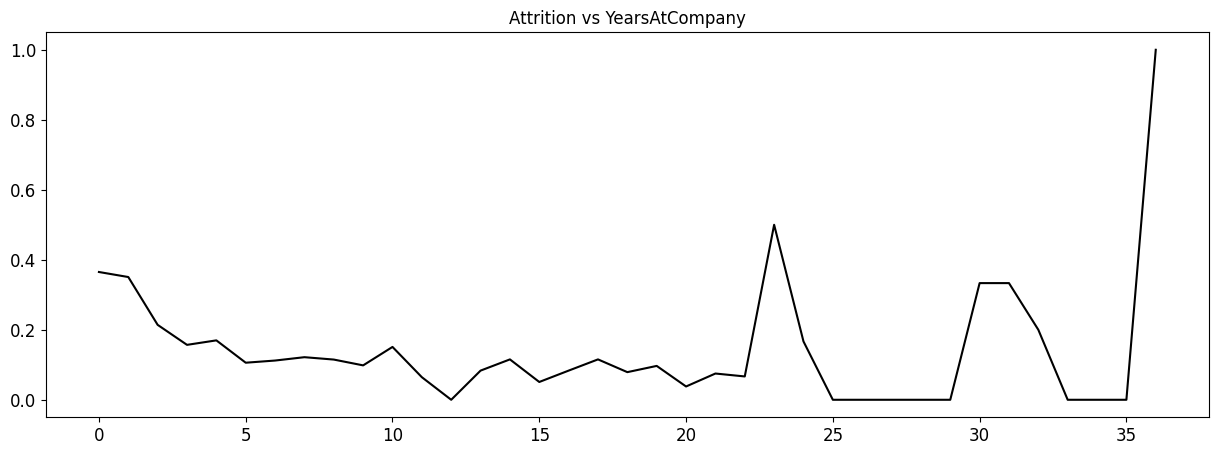

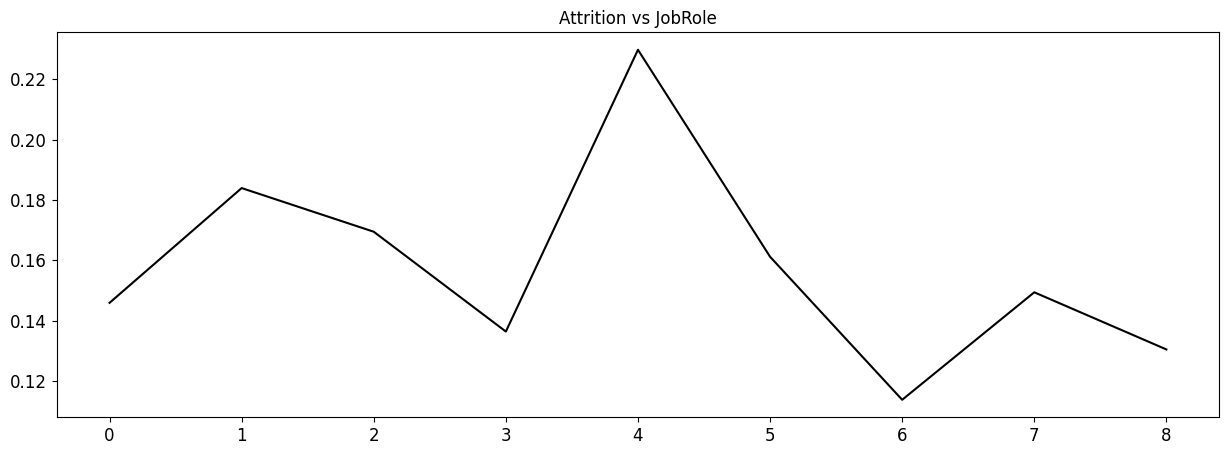

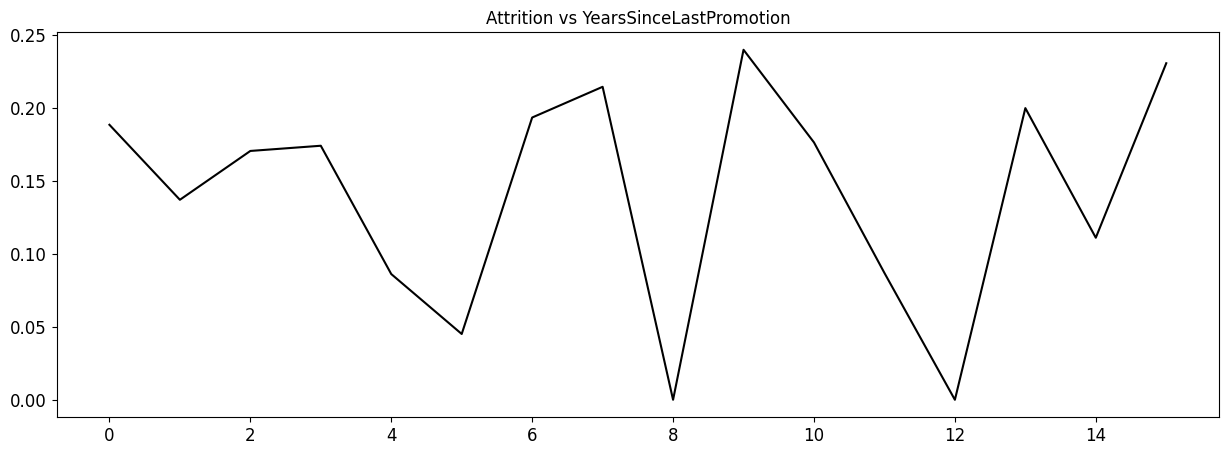

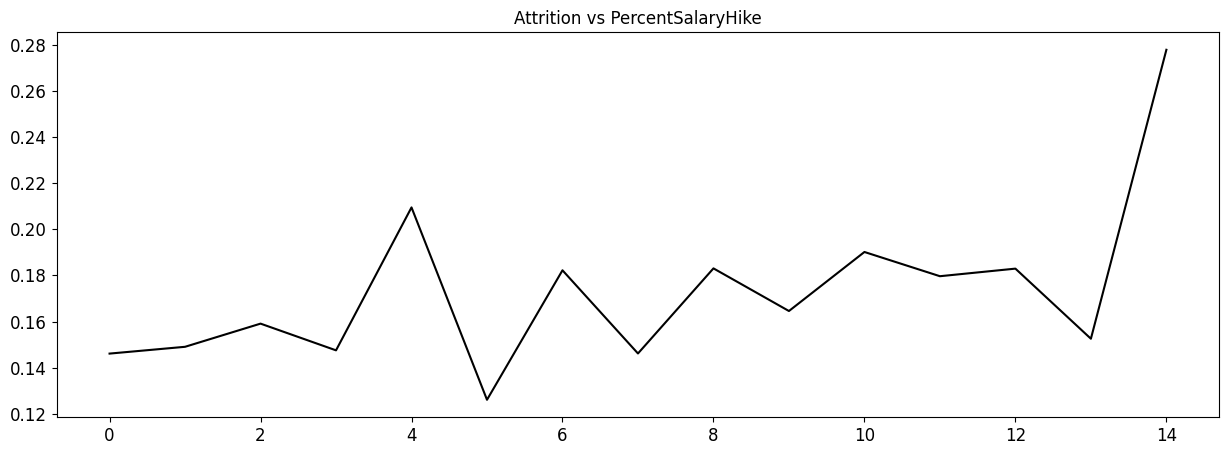

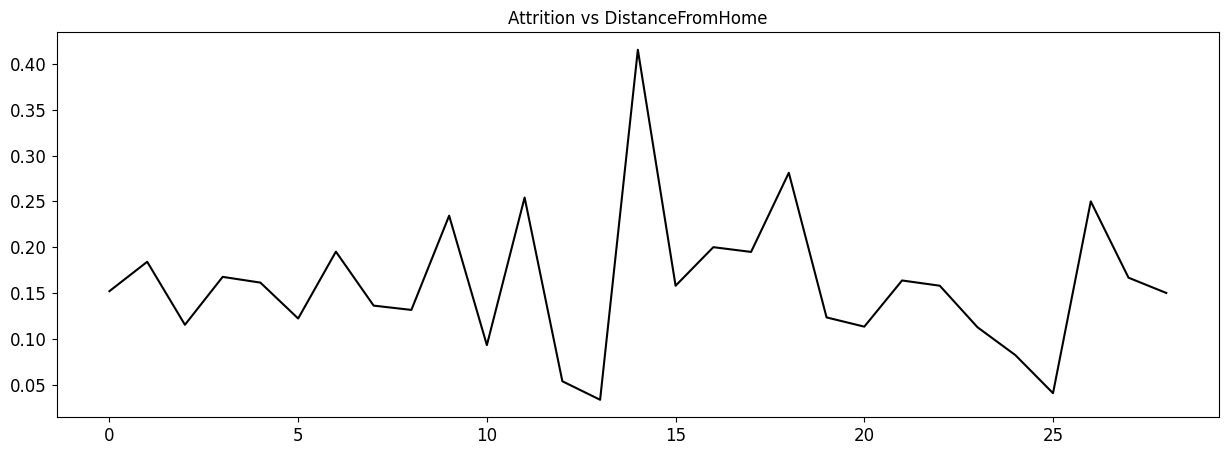

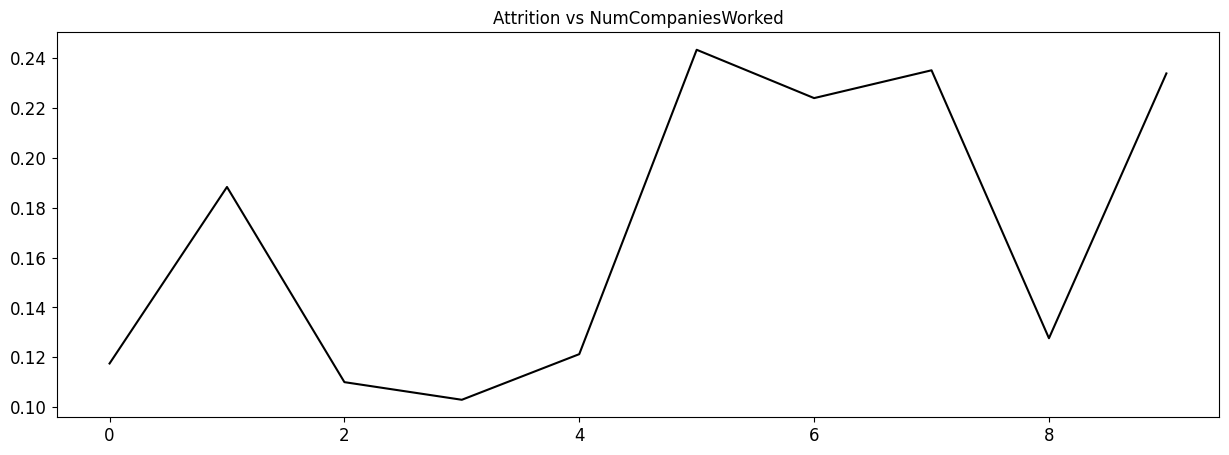

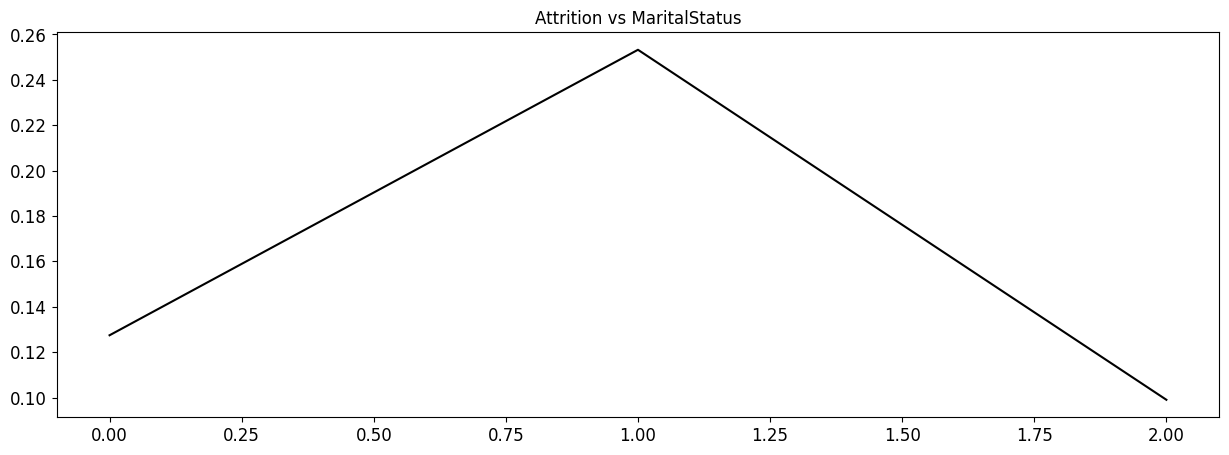

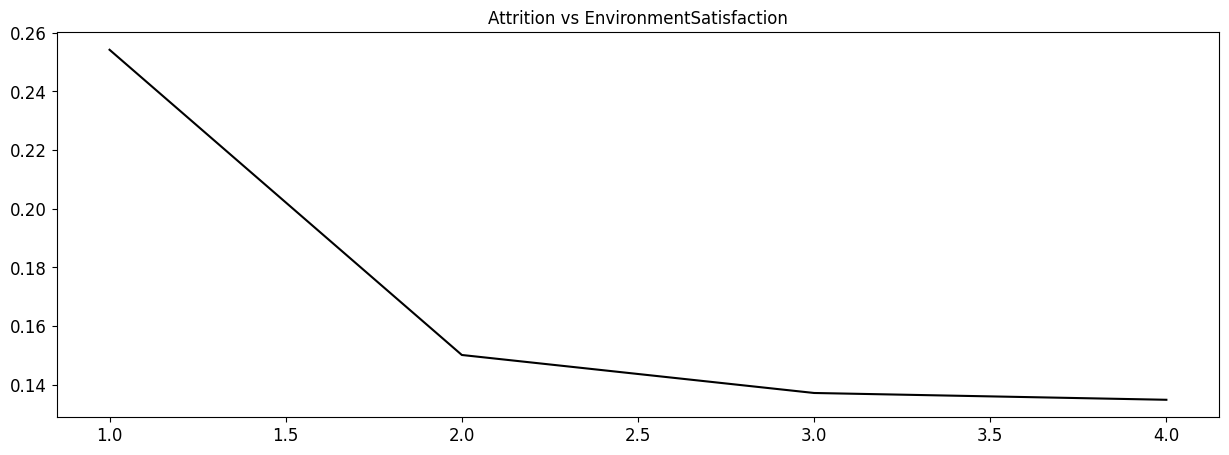

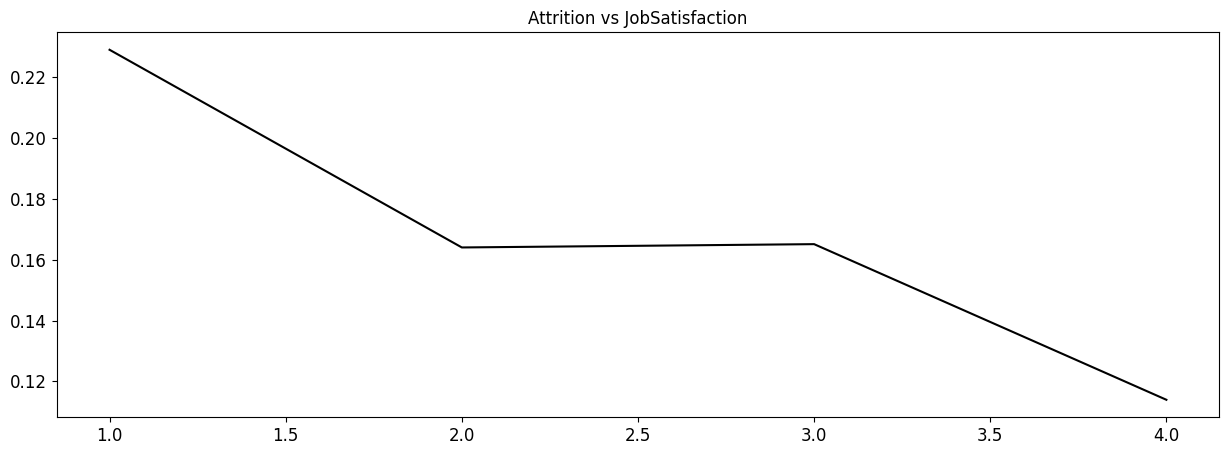

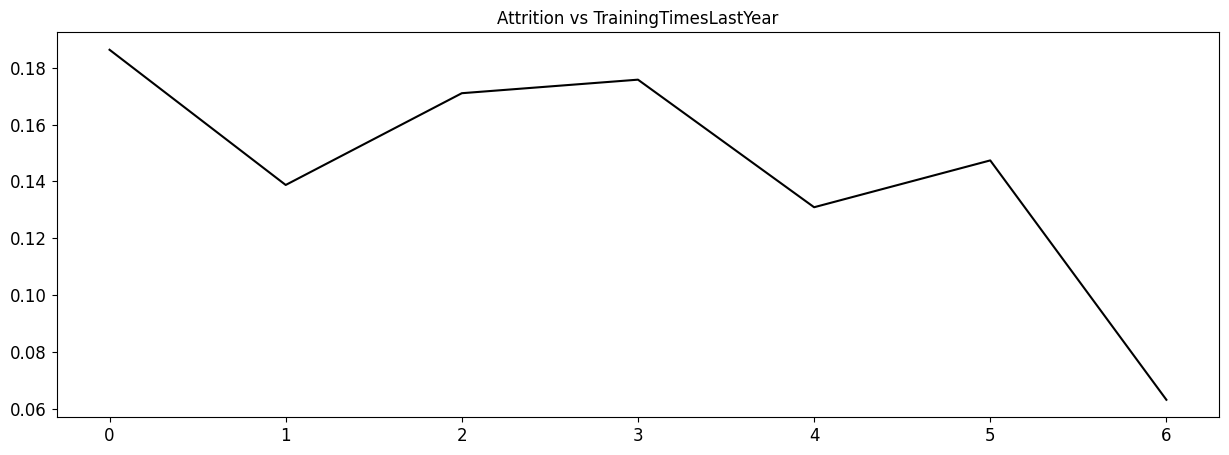

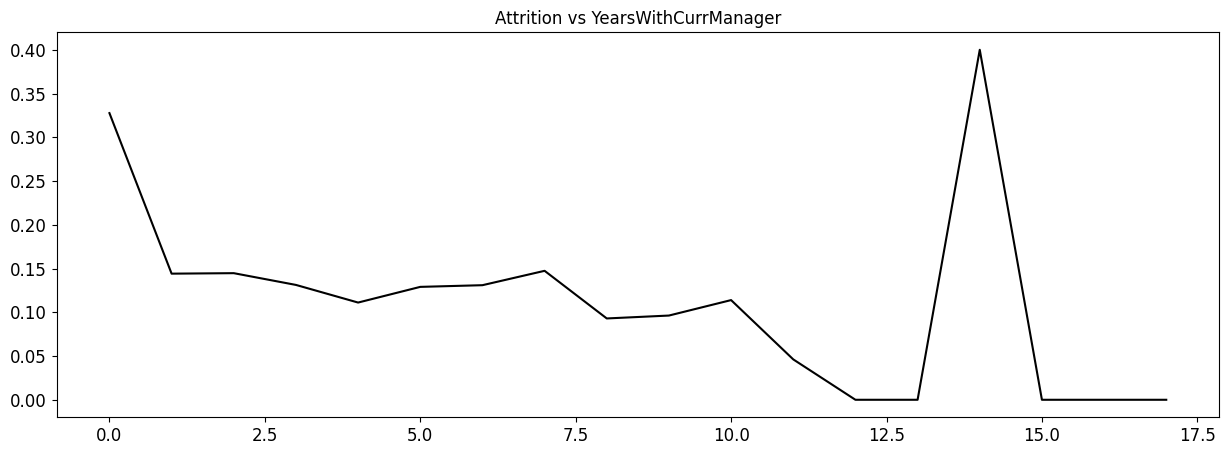

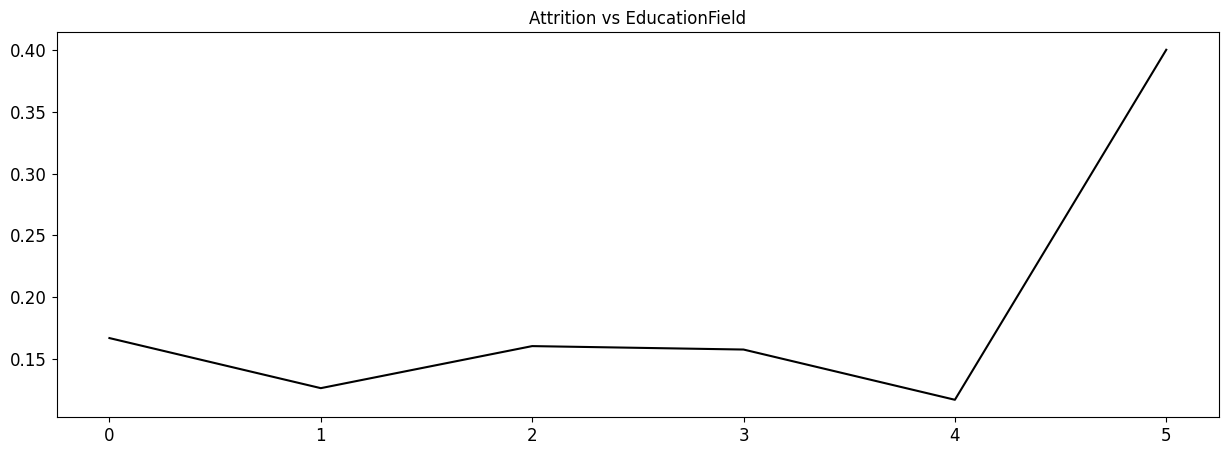

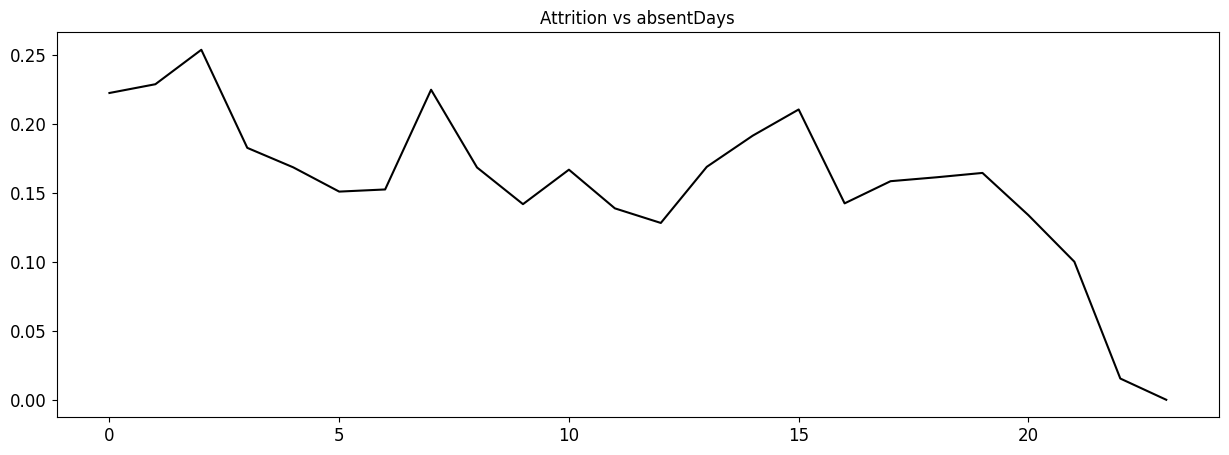

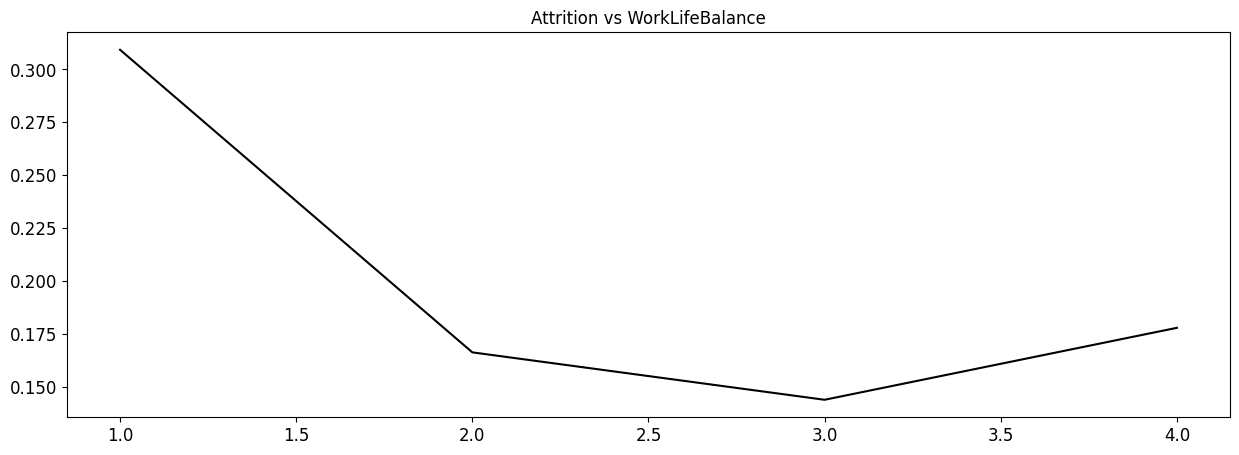

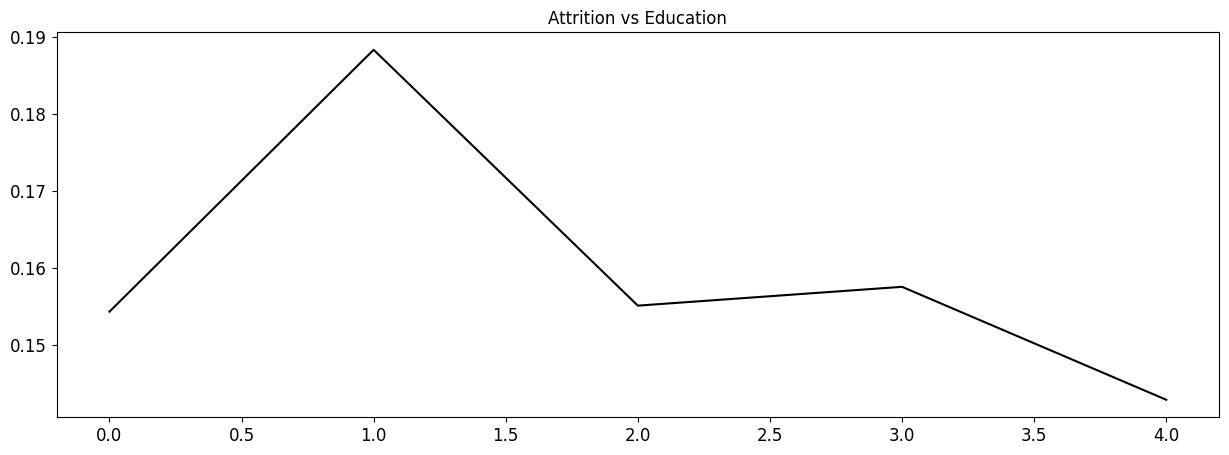

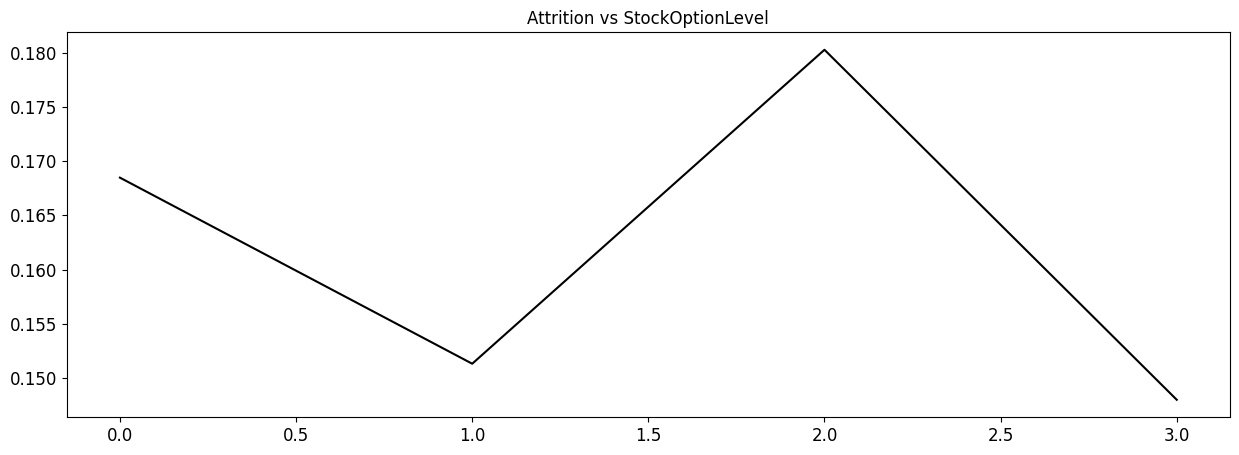

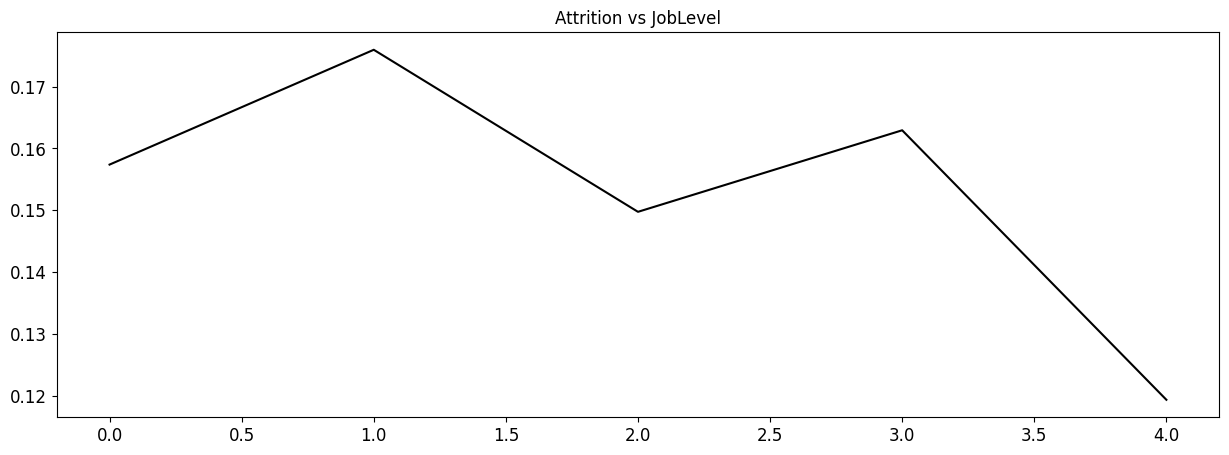

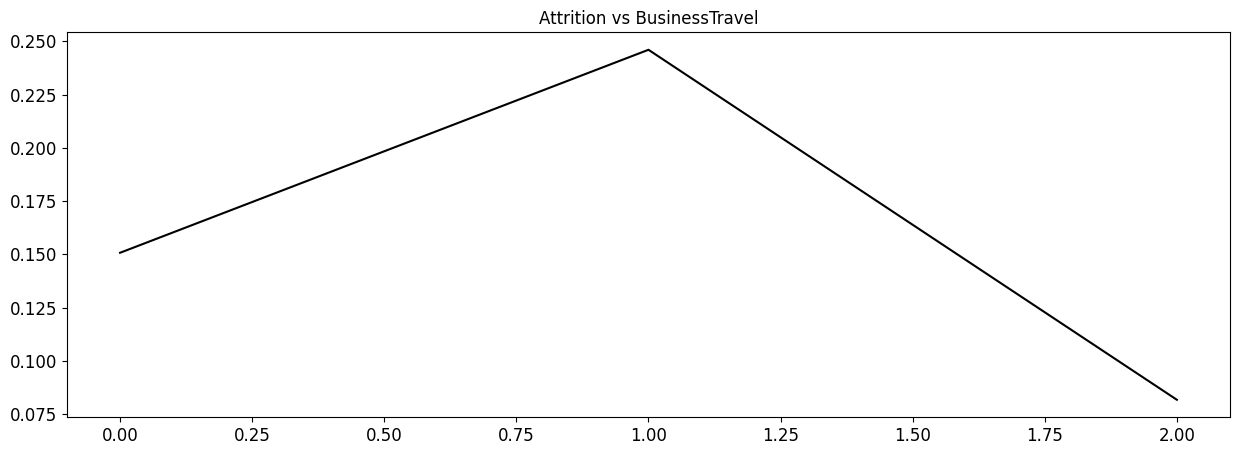

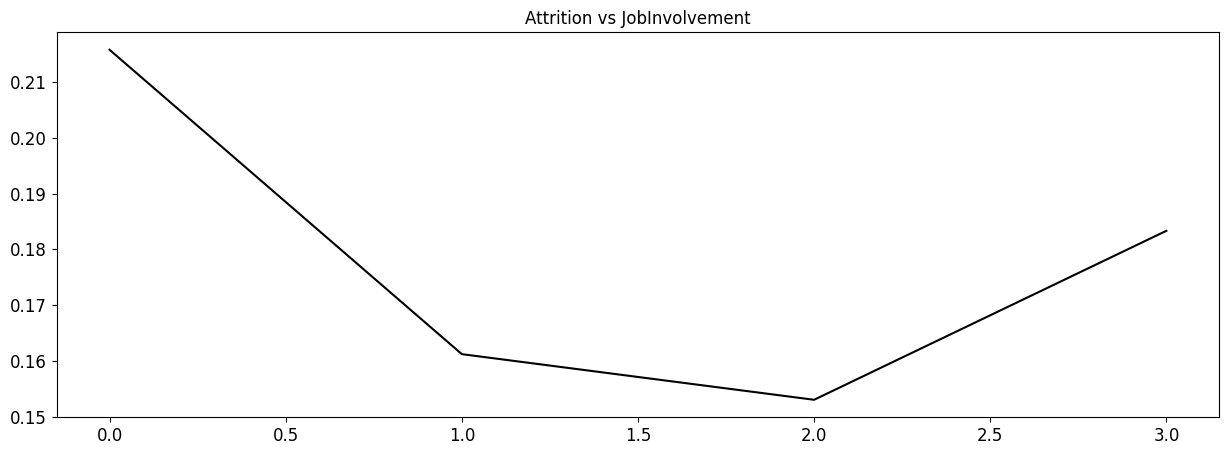

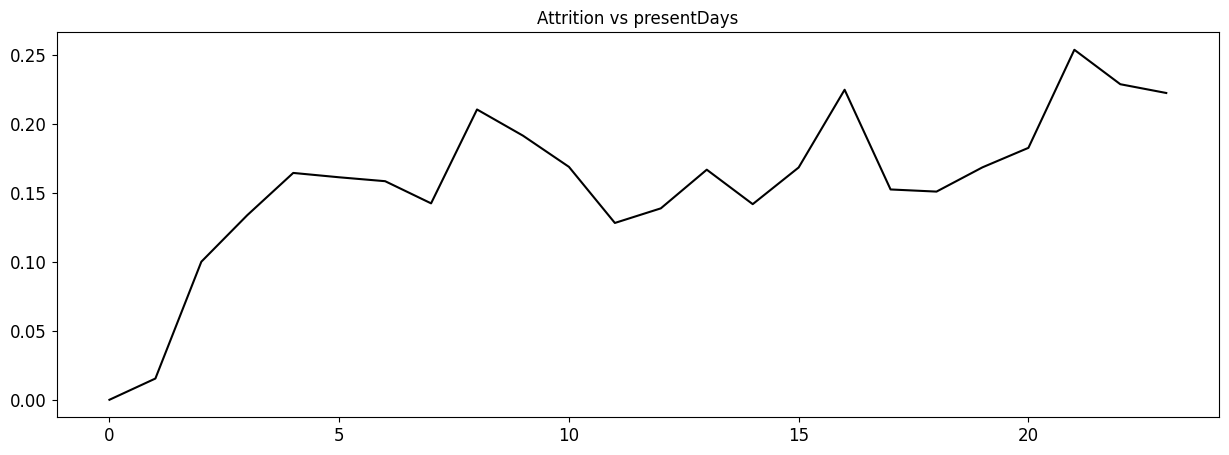

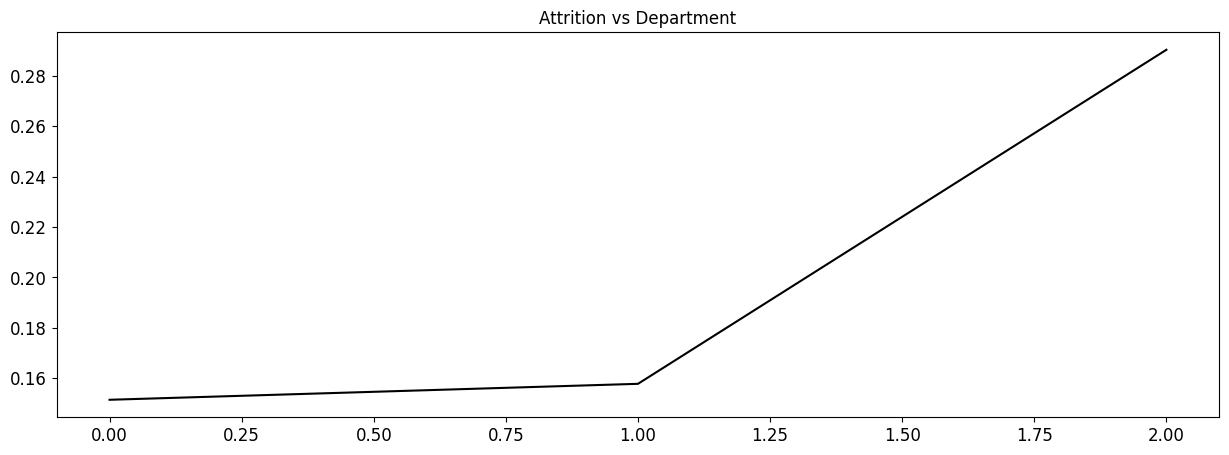

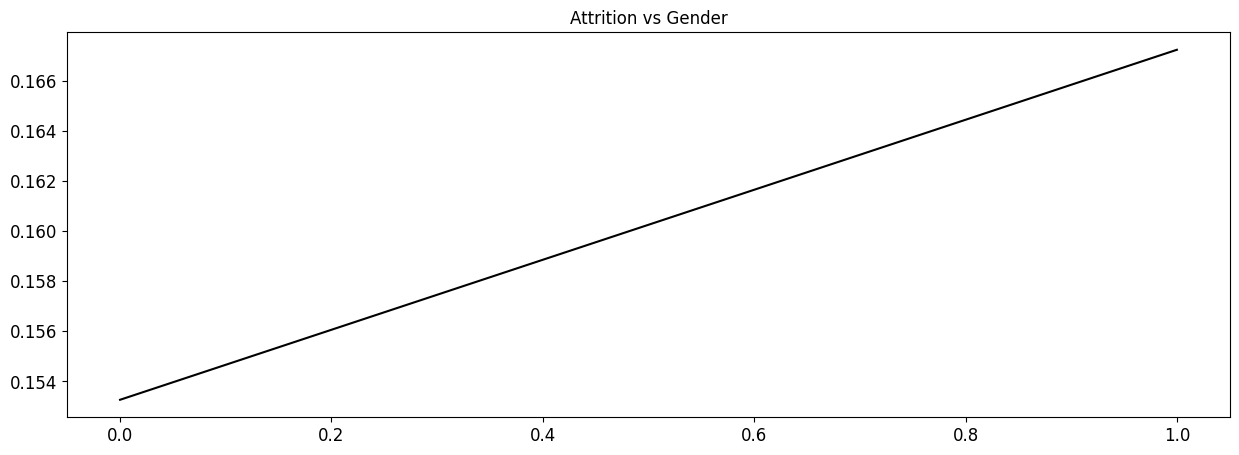

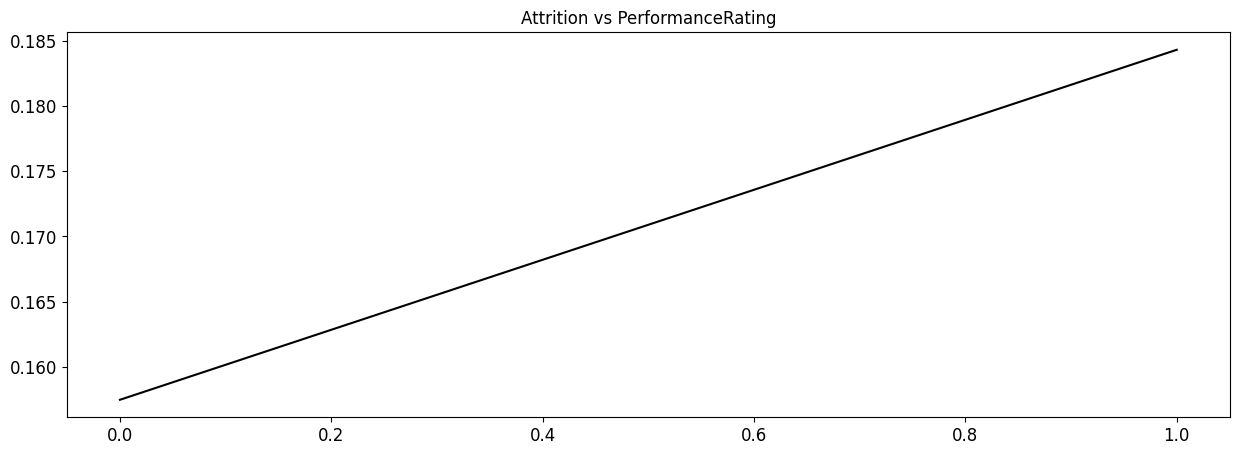

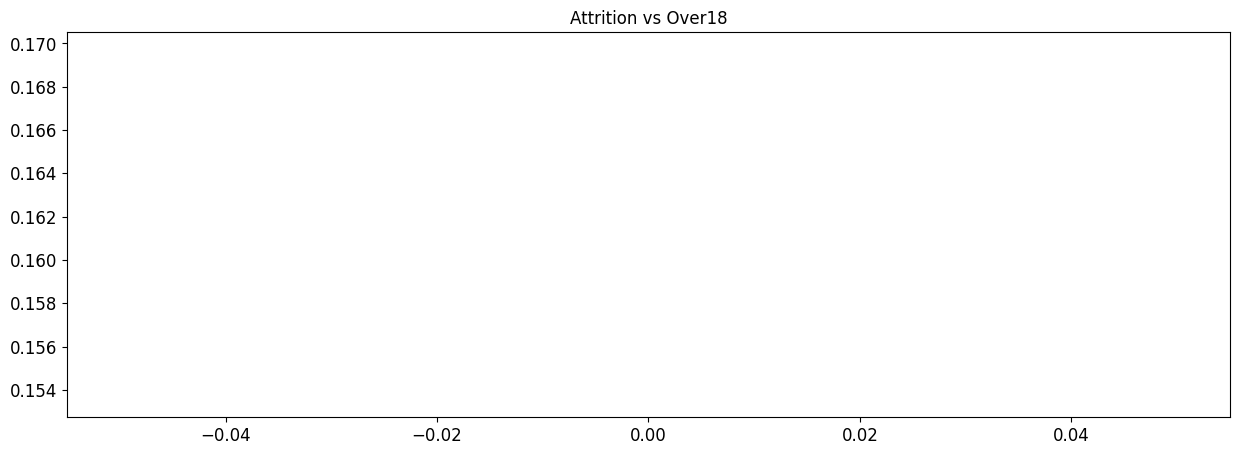

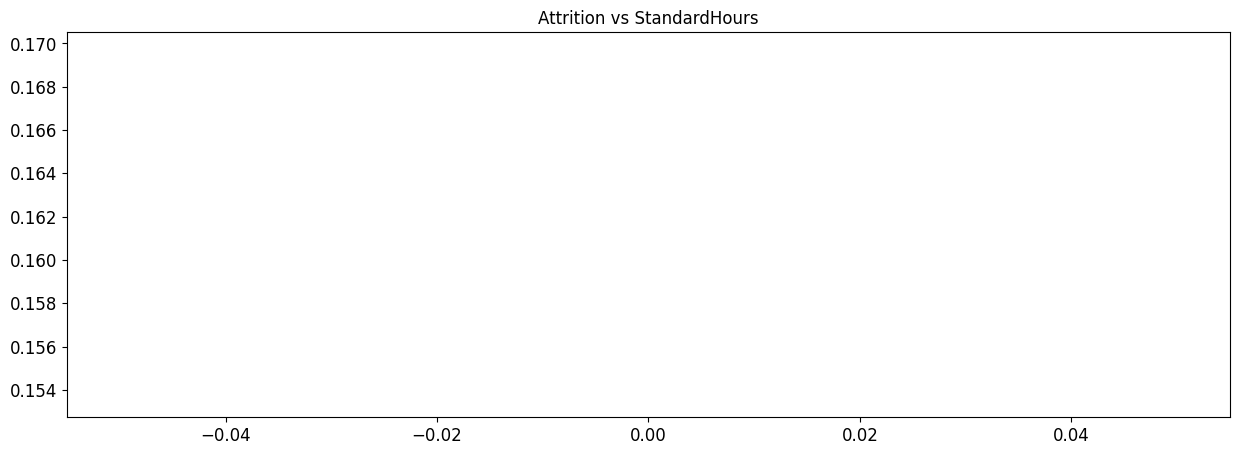

In [20]:
# get correlation matrix
corr = employeeData.corr()

# plot attrition
plt.figure(figsize=(10, 10))
plt.title('Attrition')
plt.imshow(corr['Attrition'].values.reshape(1, -1), cmap='hot', interpolation='nearest')
plt.xticks(range(len(corr['Attrition'])), corr['Attrition'].index, rotation=90)
plt.yticks(range(1), ['Attrition'])

plt.show()

# Plot attrition vs top 5 features
for f in importances['feature']:
    # Split each age into a group and find out that group's attrition rate
    g = employeeData.groupby(f)['Attrition'].mean()

    # Plot the attrition rate vs age
    plt.figure(figsize=(15, 5))

    plt.title(f'Attrition vs {f}')
    plt.plot(g.index, g.values, 'k-')

    plt.show()

## Calculs des scores de préscision à l'aide de différentes métriques

In [ ]:
pred = randomForest.predict(xTest)

In [ ]:
f1_score(yTest, pred, zero_division=1)

In [ ]:
cross_val_score(randomForest, xTrain, yTrain, cv=5, scoring="accuracy")

In [ ]:
confusion_matrix(yTest, pred)

In [ ]:
accuracy_score(yTest, pred)

In [ ]:
precision_score(yTest, pred)

In [ ]:
recall_score(yTest, pred)